In [1]:
import os
import os.path as osp
import re

import numpy as np
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
import random

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import SplineConv
from torch_geometric.typing import WITH_TORCH_SPLINE_CONV
from torch_geometric.data import Dataset, Data

/opt/anaconda3/envs/pyg/lib/python3.12/site-packages/torch_geometric/typing.py:54: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/opt/anaconda3/envs/pyg/lib/python3.12/site-packages/libpyg.so, 0x0006): Library not loaded: /Library/Frameworks/Python.framework/Versions/3.12/Python
  Referenced from: <7BF3ABB0-5875-3736-8AB2-1784D3EFB687> /opt/anaconda3/envs/pyg/lib/python3.12/site-packages/libpyg.so
  Reason: tried: '/Library/Frameworks/Python.framework/Versions/3.12/Python' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/Python.framework/Versions/3.12/Python' (no such file), '/Library/Frameworks/Python.framework/Versions/3.12/Python' (no such file)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/opt/anaconda3/envs/pyg/lib/python3.12/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/opt/anaconda3/

In [2]:
if not WITH_TORCH_SPLINE_CONV:
    quit("This example requires 'torch-spline-conv'")
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
"""
This function `read_mesh(filename)` processes a VTK file containing mesh data to extract points, elements, and scalar values.

Steps:
1. **Parse Points**:
   - Reads the coordinates of points from the VTK file.
   - Handles potential duplicate points by removing duplicates and mapping original indices to the new unique points.

2. **Extract Scalar Values (`phi`)**:
   - Reads scalar values (e.g., `phi`) associated with each point from the POINT_DATA section of the VTK file.
   - Averages scalar values if there are duplicate points.

3. **Parse Elements**:
   - Reads elements (cells) and remaps their point indices to match the deduplicated points.

4. **Compute Edges and Attributes**:
   - Identifies edges by connecting nodes within each element.
   - Computes attributes for each edge, such as the Euclidean distance between connected nodes.
   - All edges are included regardless of length.

5. **Return Values**:
   - `unique_points`: Array of deduplicated point coordinates.
   - `deduplicated_phi`: Scalar values associated with the deduplicated points.
   - `elements`: Array of elements with remapped point indices.
   - `edge_attributes`: DataFrame containing edge connections (node pairs) and their computed distances.

Usage:
- Call this function with the path to a VTK file to extract and process the mesh data.
- The returned data can be used for further mesh analysis, visualization, or as input to other computational methods.
"""

def is_point_on_segment(p, q, r, tolerance=1e-6):
    """Check if point r lies on the line segment pq."""
    # Check if r is collinear with p and q
    collinear = np.isclose(np.cross(q - p, r - p), 0, atol=tolerance)
    if not collinear:
        return False
    
    # Check if r is within the bounds of the segment pq
    within_bounds = np.all(r >= np.minimum(p, q)) and np.all(r <= np.maximum(p, q))
    return within_bounds

def grid_hash(points, grid_size=1.0):
    """Hashes points into a spatial grid."""
    grid = defaultdict(list)
    for idx, point in enumerate(points):
        grid_key = (int(point[0] // grid_size), int(point[1] // grid_size))
        grid[grid_key].append(idx)
    return grid

def get_nearby_points(p, q, grid, points, grid_size=1.0):
    """Returns points in grid cells near the line segment pq."""
    p_grid_key = (int(p[0] // grid_size), int(p[1] // grid_size))
    q_grid_key = (int(q[0] // grid_size), int(q[1] // grid_size))
    
    min_key = (min(p_grid_key[0], q_grid_key[0]), min(p_grid_key[1], q_grid_key[1]))
    max_key = (max(p_grid_key[0], q_grid_key[0]), max(p_grid_key[1], q_grid_key[1]))

    nearby_points = []
    for i in range(min_key[0], max_key[0] + 1):
        for j in range(min_key[1], max_key[1] + 1):
            if (i, j) in grid:
                nearby_points.extend(grid[(i, j)])
    return nearby_points

def split_edge_by_nodes(edge, points, grid, grid_size=1.0):
    """Split an edge if any nodes with odd coordinates lie on it."""
    p, q = edge
    split_points = [p]
    
    nearby_points = get_nearby_points(points[p], points[q], grid, points, grid_size)
    for r in nearby_points:
        if is_point_on_segment(points[p], points[q], points[r]):
            # print(f"Splitting edge {p}-{q} at point {r}")  # Diagnostic print
            split_points.append(r)
    
    split_points.append(q)
    split_points = sorted(set(split_points), key=lambda idx: np.linalg.norm(points[split_points[0]] - points[idx]))
    
    return [(split_points[i], split_points[i + 1]) for i in range(len(split_points) - 1)]

def read_mesh(filename, grid_size=1.0, verbose=1.0):
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Parse points and handle potential duplicates
    points_start = lines.index(next(line for line in lines if 'POINTS' in line))
    num_points = int(lines[points_start].split()[1])
    points_end = points_start + 1 + num_points

    raw_points = []
    for line in lines[points_start + 1:points_end]:
        x, y, _ = map(float, line.strip().split())
        raw_points.append([x, y])
    raw_points = np.array(raw_points)

    # Remove duplicates from points array and map original indices to new indices
    unique_points, indices = np.unique(raw_points, axis=0, return_inverse=True)

    # Initialize dictionary to store all scalar fields
    scalar_fields = {}

    # Loop through all scalar fields in the VTK file
    i = 0
    while i < len(lines):
        if 'SCALARS' in lines[i]:
            # Extract the scalar field name
            field_name = lines[i].split()[1]
            # Find the lookup table start for this scalar field
            lookup_table_start = i + 2  # SCALARS + 1 line + LOOKUP_TABLE line
            values = []
            for j in range(lookup_table_start, lookup_table_start + num_points):
                values.append(float(lines[j].strip()))
            scalar_fields[field_name] = np.array(values)
            i = lookup_table_start + num_points  # Move index forward to next scalar field
        else:
            i += 1

    # Combine scalar values for duplicated points (e.g., averaging)
    deduplicated_data = {}
    for name, data in scalar_fields.items():
        deduplicated_values = np.zeros(len(unique_points))
        count = np.zeros(len(unique_points))
        for i, idx in enumerate(indices):
            deduplicated_values[idx] += data[i]
            count[idx] += 1
        deduplicated_values /= count  # Average the values for duplicates
        deduplicated_data[name] = deduplicated_values

    # Read elements and remap their point indices to the deduplicated indices
    cells_start = lines.index(next(line for line in lines if 'CELLS' in line))
    num_cells = int(lines[cells_start].split()[1])
    cells_end = cells_start + 1 + num_cells

    elements = []
    for line in lines[cells_start + 1:cells_end]:
        data = list(map(int, line.strip().split()))
        remapped_data = [indices[idx] for idx in data[1:1+data[0]]]
        elements.append(remapped_data)
    elements = np.array(elements)

    # Create spatial hash grid
    grid = grid_hash(unique_points, grid_size)
    
    # Compute edges and their attributes
    edges = set()
    for element in elements:
        for i in range(len(element)):
            a, b = sorted([element[i], element[(i + 1) % len(element)]])
            edges.add((a, b))

    # Check and split edges where necessary
    new_edges = set()
    total_edges = len(edges)
    for i, edge in enumerate(edges):
        # if verbose == 1 and i % 1000 == 0:  # Print progress every 100 edges
            # print(f"Processing edge {i + 1}/{total_edges} ({(i + 1) / total_edges * 100:.2f}%)")
        
        split_edges = split_edge_by_nodes(edge, unique_points, grid, grid_size)
        new_edges.update(split_edges)

    edge_attributes = []
    for a, b in new_edges:
        dx, dy = unique_points[a] - unique_points[b]
        distance = np.sqrt(dx**2 + dy**2)
        edge_attributes.append([a, b, distance])
    
    edge_attributes = pd.DataFrame(edge_attributes, columns=['node1', 'node2', 'distance'])
    
    return unique_points, deduplicated_data, elements, edge_attributes

# # Usage
# points, point_data, elements, edge_attributes = read_mesh('./dataset/NDD/physics_allparticle_044600.vtk')
# print("Points (deduplicated):", points)
# print("Scalar Fields:", point_data)
# print("Elements (remapped indices):", elements)
# print("Edge Attributes:", edge_attributes)


In [4]:
def sort_key_func(filename):
    """
    Extracts numbers from a filename and converts them to an integer for sorting.
    """
    numbers = re.findall(r'\d+', filename)
    return int(numbers[0]) if numbers else float('inf')

def read_all_vtk_files_sorted(folder_path, grid_size=1.0):
    """
    Reads all VTK files in the specified folder using the read_mesh function, sorted by numeric order in filenames.

    Args:
        folder_path (str): Path to the folder containing VTK files.
        grid_size (float): The grid size for spatial hashing in the read_mesh function.

    Returns:
        list: A list of tuples where each tuple contains the output of the read_mesh function
              (unique_points, deduplicated_data, elements, edge_attributes) for each file.
    """
    vtk_files = [file for file in os.listdir(folder_path) if file.endswith('.vtk')]
    vtk_files_sorted = sorted(vtk_files, key=sort_key_func)

    total_files = len(vtk_files_sorted)
    vtk_data_list = []
    for i, filename in enumerate(vtk_files_sorted):
        filepath = os.path.join(folder_path, filename)
        progress_percent = (i + 1) / total_files * 100
        if i % 10 == 0:  # Print progress every 100 edges
            print(f"Reading {filename}... ({progress_percent:.2f}%)")
        points, point_data, elements, edge_attributes = read_mesh(filepath, grid_size)
        vtk_data_list.append((points, point_data, elements, edge_attributes))

    return vtk_data_list

# Example usage:
folder_path = "./dataset/NDD"  # Replace with your folder path containing VTK files
vtk_data_list = read_all_vtk_files_sorted(folder_path)

# Example: Accessing the data from the first VTK file
first_points, first_point_data, first_elements, first_edge_attributes = vtk_data_list[0]
print("First VTK File - Points:", first_points)
print("First VTK File - Scalar Fields:", first_point_data)
print("First VTK File - Elements:", first_elements)
print("First VTK File - Edge Attributes:", first_edge_attributes)


Reading physics_allparticle_000000.vtk... (1.96%)
Reading physics_allparticle_001000.vtk... (21.57%)
Reading physics_allparticle_002000.vtk... (41.18%)
Reading physics_allparticle_003000.vtk... (60.78%)
Reading physics_allparticle_004000.vtk... (80.39%)
Reading physics_allparticle_005000.vtk... (100.00%)
First VTK File - Points: [[ 0.       0.     ]
 [ 0.       3.83333]
 [ 0.       6.     ]
 ...
 [48.      42.     ]
 [48.      44.1667 ]
 [48.      48.     ]]
First VTK File - Scalar Fields: {'phi': array([0., 0., 0., ..., 0., 0., 0.]), 'synaptogenesis': array([0., 0., 0., ..., 0., 0., 0.]), 'tubulin': array([0., 0., 0., ..., 0., 0., 0.]), 'tips': array([0., 0., 0., ..., 0., 0., 0.]), 'theta': array([0.24    , 0.331667, 0.11    , ..., 0.715001, 0.875833, 0.14    ])}
First VTK File - Elements: [[706 708 765 763]
 [708 709 766 765]
 [709 710 767 766]
 ...
 [750 751 786 785]
 [781 782 804 803]
 [782 783 805 804]]
First VTK File - Edge Attributes:       node1  node2  distance
0       838    

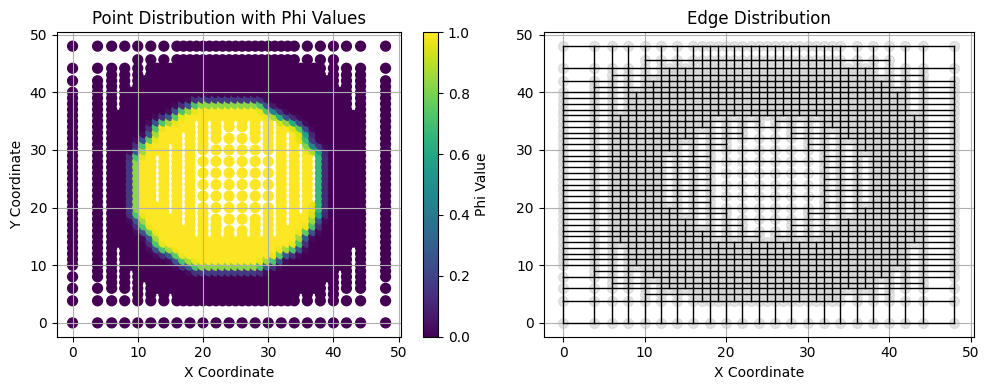

In [5]:
def plot_graph_components(points, phi, edges):
    """
    Plots nodes and edges in subplots.
    
    Args:
        points (numpy.ndarray): Nx2 array of point coordinates.
        phi (numpy.ndarray): Array of scalar values associated with each point.
        edges (numpy.ndarray): Nx2 array of index pairs representing edges.
    """
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns subplot

    # Plot points with scalar values
    scatter = axs[0].scatter(points[:, 0], points[:, 1], c=phi, cmap='viridis', s=50, marker='o')
    axs[0].set_title('Point Distribution with Phi Values')
    axs[0].set_xlabel('X Coordinate')
    axs[0].set_ylabel('Y Coordinate')
    fig.colorbar(scatter, ax=axs[0], label='Phi Value')
    axs[0].grid(True)

    # Plot edges
    axs[1].scatter(points[:, 0], points[:, 1], c='lightgray', s=50, alpha=0.6)  # plot points for reference
    for edge in edges:
        point_a = points[edge[0]]
        point_b = points[edge[1]]
        axs[1].plot([point_a[0], point_b[0]], [point_a[1], point_b[1]], 'k-', linewidth=1)  # 'k-' for black edges
    axs[1].set_title('Edge Distribution')
    axs[1].set_xlabel('X Coordinate')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# Example usage:
point_data = first_point_data
points = first_points
edge_attributes = first_edge_attributes

phi = np.round(np.array(point_data['phi']), decimals=2)  # Assuming point_data dictionary has a 'phi' key

# Extract edges from DataFrame
edges = edge_attributes[['node1', 'node2']].values

# Call the function with the necessary data
plot_graph_components(points, phi, edges)


In [6]:
import torch
import numpy as np
from torch_geometric.data import Data
import pandas as pd

def calculate_pseudo_coordinates(points, edge_index):
    """Calculate pseudo-coordinates for each edge based on node coordinates."""
    pseudo_coords = []
    for src, dest in edge_index.t():
        # Calculate the difference in x and y coordinates between connected nodes
        delta_x = points[dest, 0] - points[src, 0]
        delta_y = points[dest, 1] - points[src, 1]
        # Append the pseudo-coordinates (delta_x, delta_y)
        pseudo_coords.append([delta_x, delta_y])

    # Convert to a tensor
    pseudo_coords = torch.tensor(pseudo_coords, dtype=torch.float)
    
    # Normalize to [0, 1] as required by SplineConv
    pseudo_coords = (pseudo_coords - pseudo_coords.min(0, keepdim=True)[0]) / (
        pseudo_coords.max(0, keepdim=True)[0] - pseudo_coords.min(0, keepdim=True)[0])
    
    return pseudo_coords

def create_graph_data(points, elements, point_data, edge_attributes, next_points, next_phi):
    # Concatenate point_data into x
    point_features = np.hstack([points] + [point_data[key][:, np.newaxis] for key in point_data.keys()])
    x = torch.tensor(point_features, dtype=torch.float)  # Node features based on coordinates and scalar fields
    
    # Prepare 'phi' values from the next dataset, ensuring alignment
    next_phi_dict = {tuple(point): phi for point, phi in zip(next_points, next_phi)}
    
    # Ensure 'phi' values are only assigned to nodes that exist in both current and next dataset
    y_values = []
    for point in points:
        if tuple(point) in next_phi_dict:
            y_values.append(next_phi_dict[tuple(point)])
        else:
            y_values.append(0)  # Default value if no matching point is found

    y = torch.tensor(y_values, dtype=torch.float)

    # Use precomputed edges and calculate pseudo-coordinates as edge attributes
    edge_index = torch.tensor(edge_attributes[['node1', 'node2']].to_numpy().T, dtype=torch.long)
    
    # Calculate the pseudo-coordinates based on node positions
    pseudo_coords = calculate_pseudo_coordinates(points, edge_index)

    # Create the graph data object
    data = Data(x=x, edge_index=edge_index, edge_attr=pseudo_coords, y=y)
    return data

def create_graphs_from_datasets(vtk_data_list):
    graph_data_list = []
    # Only process up to the second-to-last dataset
    for i in range(len(vtk_data_list) - 1):
        points, point_data, elements, edge_attributes = vtk_data_list[i]
        next_points, next_point_data, _, _ = vtk_data_list[i + 1]
        next_phi = next_point_data['phi']  # 'phi' from the next dataset
        data = create_graph_data(points, elements, point_data, edge_attributes, next_points, next_phi)
        graph_data_list.append(data)
    return graph_data_list

# Example usage
# Assuming vtk_data_list is available and contains the required data
graph_data_list = create_graphs_from_datasets(vtk_data_list)

# Print details of the graph data objects
for i, data in enumerate(graph_data_list):
    print(f"Graph {i+1}:")
    print(data)
    print("-" * 60)


Graph 1:
Data(x=[1444, 7], edge_index=[2, 2778], edge_attr=[2778, 2], y=[1444])
------------------------------------------------------------
Graph 2:
Data(x=[1444, 7], edge_index=[2, 2778], edge_attr=[2778, 2], y=[1444])
------------------------------------------------------------
Graph 3:
Data(x=[1608, 7], edge_index=[2, 3083], edge_attr=[3083, 2], y=[1608])
------------------------------------------------------------
Graph 4:
Data(x=[1704, 7], edge_index=[2, 3272], edge_attr=[3272, 2], y=[1704])
------------------------------------------------------------
Graph 5:
Data(x=[1833, 7], edge_index=[2, 3501], edge_attr=[3501, 2], y=[1833])
------------------------------------------------------------
Graph 6:
Data(x=[1923, 7], edge_index=[2, 3660], edge_attr=[3660, 2], y=[1923])
------------------------------------------------------------
Graph 7:
Data(x=[2019, 7], edge_index=[2, 3851], edge_attr=[3851, 2], y=[2019])
------------------------------------------------------------
Graph 8:
Data

In [7]:
import torch
from torch_geometric.data import Data
import numpy as np

def combine_graph_data(graph_data_list):
    combined_x = []
    combined_edge_index = []
    combined_edge_attr = []
    combined_y = []
    
    node_offset = 0  # To adjust edge indices for each graph
    
    for data in graph_data_list:
        num_nodes = data.x.size(0)
        
        # Append node features
        combined_x.append(data.x)
        
        # Adjust and append edge indices
        adjusted_edge_index = data.edge_index + node_offset
        combined_edge_index.append(adjusted_edge_index)
        
        # Append edge attributes
        combined_edge_attr.append(data.edge_attr)
        
        # Append labels
        combined_y.append(data.y)
        
        # Update node offset
        node_offset += num_nodes
    
    # Concatenate all components
    combined_x = torch.cat(combined_x, dim=0)
    combined_edge_index = torch.cat(combined_edge_index, dim=1)
    combined_edge_attr = torch.cat(combined_edge_attr, dim=0)
    combined_y = torch.cat(combined_y, dim=0)
    
    # Create the combined Data object
    combined_data = Data(x=combined_x, edge_index=combined_edge_index, edge_attr=combined_edge_attr, y=combined_y)
    
    return combined_data

# Clear existing 'data' variable if it exists
data = None

# Combine all Data objects into a single Data object
data = combine_graph_data(graph_data_list)

# Print the combined data object details
print("Combined Graph Data:")
print(data)


Combined Graph Data:
Data(x=[125644, 7], edge_index=[2, 242482], edge_attr=[242482, 2], y=[125644])


In [8]:
# import torch
# import numpy as np
# from torch_geometric.data import Data
# import pandas as pd

# def create_graph_data(points, elements, point_data, edge_attributes, next_points, next_phi):
#     # Concatenate point_data into x
#     point_features = np.hstack([points] + [point_data[key][:, np.newaxis] for key in point_data.keys()])
#     x = torch.tensor(point_features, dtype=torch.float)  # Node features based on coordinates and scalar fields
    
#     # Prepare 'phi' values from the next dataset, ensuring alignment
#     next_phi_dict = {tuple(point): phi for point, phi in zip(next_points, next_phi)}
    
#     # Ensure 'phi' values are only assigned to nodes that exist in both current and next dataset
#     y_values = []
#     for point in points:
#         if tuple(point) in next_phi_dict:
#             y_values.append(next_phi_dict[tuple(point)])
#         else:
#             y_values.append(0)  # Default value if no matching point is found

#     y = torch.tensor(y_values, dtype=torch.float)

#     # Use precomputed edges and edge attributes from the dataframe
#     edge_index = torch.tensor(edge_attributes[['node1', 'node2']].to_numpy().T, dtype=torch.long)
#     edge_attr = torch.tensor(edge_attributes['distance'].to_numpy(), dtype=torch.float).view(-1, 1)

#     # Create the graph data object
#     data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
#     return data

# def create_graphs_from_datasets(vtk_data_list):
#     graph_data_list = []
#     # Only process up to the second-to-last dataset
#     for i in range(len(vtk_data_list) - 1):
#         points, point_data, elements, edge_attributes = vtk_data_list[i]
#         next_points, next_point_data, _, _ = vtk_data_list[i + 1]
#         next_phi = next_point_data['phi']  # 'phi' from the next dataset
#         data = create_graph_data(points, elements, point_data, edge_attributes, next_points, next_phi)
#         graph_data_list.append(data)
#     return graph_data_list

# # Example usage
# # Assuming vtk_data_list is available and contains the required data
# graph_data_list = create_graphs_from_datasets(vtk_data_list)

# # Print details of the graph data objects
# for i, data in enumerate(graph_data_list):
#     print(f"Graph {i+1}:")
#     print(data)
#     print("-" * 60)


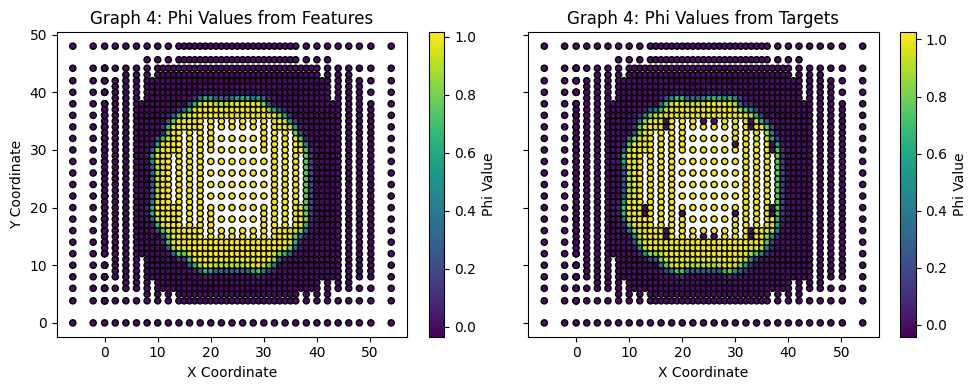

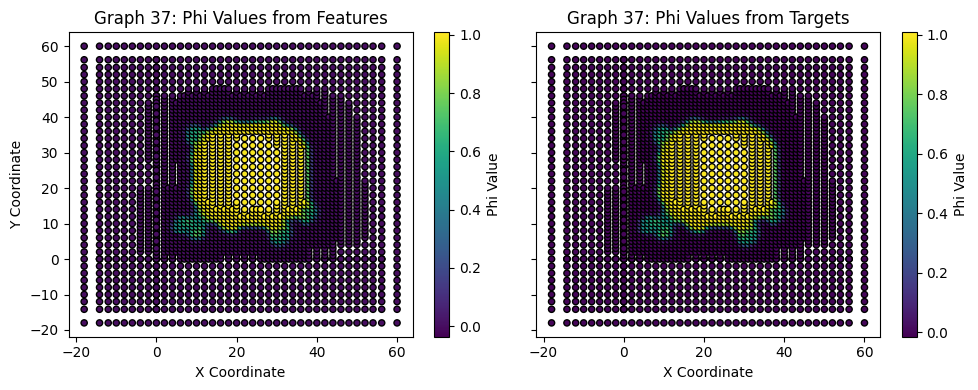

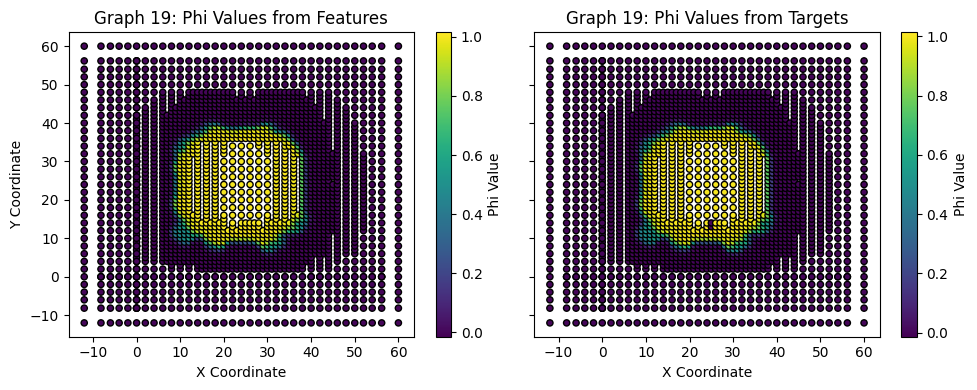

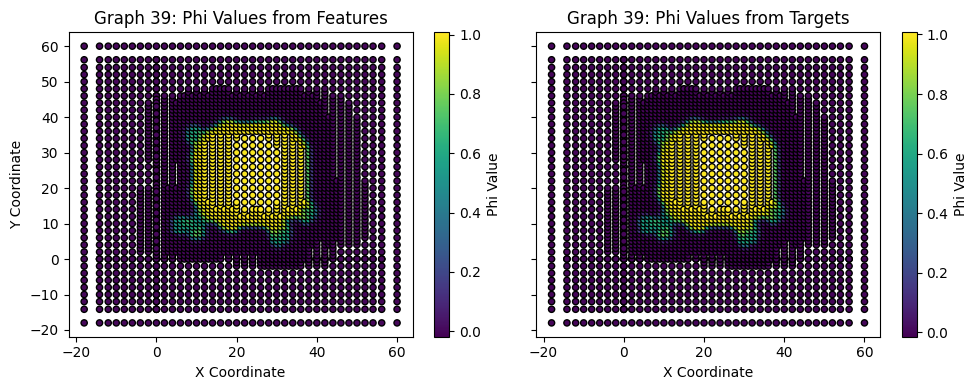

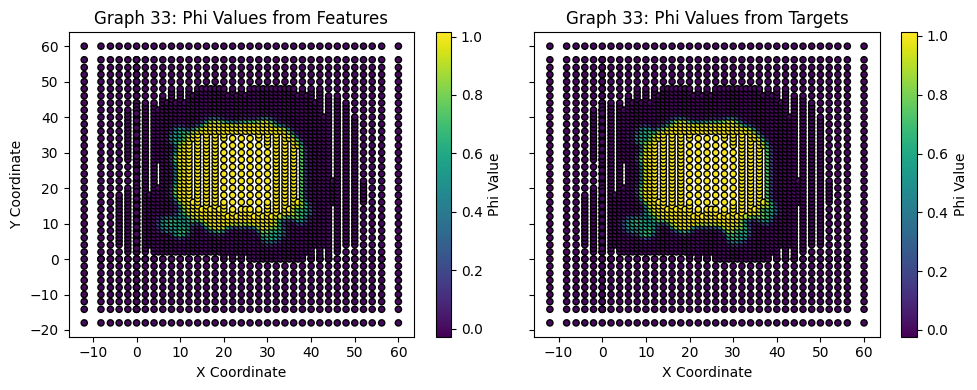

In [12]:
def visualize_graph_data(graph_data_list):
    """
    Visualizes the coordinates and two sets of 'phi' values for each randomly selected graph data object in the list.

    Args:
        graph_data_list (list): A list of Data objects from PyTorch Geometric.

    Displays:
        Scatter plots for 5 randomly selected graphs with nodes colored according to their 'phi' values from features and targets.
    """
    # Randomly select 5 graph indices if the list has more than 5 graphs
    if len(graph_data_list) > 5:
        selected_indices = random.sample(range(len(graph_data_list)), 5)
    else:
        selected_indices = range(len(graph_data_list))

    for index in selected_indices:
        data = graph_data_list[index]
        # Extract x coordinates and phi values from features (assuming phi is the last column in x)
        x_coords = data.x[:, :2].numpy()  # First two columns are coordinates
        phi_values_x = data.x[:, 2].numpy()  # Assuming the last column in x is 'phi'
        phi_values_y = data.y.numpy()  # 'phi' values used as target variable

        # Create a plot with two subplots for comparison
        fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

        # Plot 'phi' from features
        scatter1 = axs[0].scatter(x_coords[:, 0], x_coords[:, 1], c=phi_values_x, cmap='viridis', edgecolor='k', s=20)
        axs[0].set_title(f'Graph {index+1}: Phi Values from Features')
        axs[0].set_xlabel('X Coordinate')
        axs[0].set_ylabel('Y Coordinate')
        fig.colorbar(scatter1, ax=axs[0], label='Phi Value')

        # Plot 'phi' from targets
        scatter2 = axs[1].scatter(x_coords[:, 0], x_coords[:, 1], c=phi_values_y, cmap='viridis', edgecolor='k', s=20)
        axs[1].set_title(f'Graph {index+1}: Phi Values from Targets')
        axs[1].set_xlabel('X Coordinate')
        fig.colorbar(scatter2, ax=axs[1], label='Phi Value')

        # plt.grid(True)
        plt.tight_layout()
        plt.show()

# Example usage:
# Assuming 'graph_data_list' is populated with graph data objects
visualize_graph_data(graph_data_list)


In [14]:
# Ensure y (labels) is of shape [num_nodes]
data.y = data.y.view(-1)  # Ensure y is 1D [num_nodes]

# Number of nodes in the graph
num_nodes = data.x.size(0)  # Infer the number of nodes from x
num_train = int(num_nodes * 0.8)  # 80% of nodes for training
num_test = num_nodes - num_train  # 20% of nodes for testing

# Randomly permute node indices to create random train, validation, and test splits
perm = torch.randperm(num_nodes)

# Initialize masks for train and test sets
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Assign masks based on the random permutation
train_mask[perm[:num_train]] = True
test_mask[perm[num_train:]] = True

# Assign masks to the Data object
data.train_mask = train_mask
data.test_mask = test_mask

# Optional: Create a validation mask from the training set
num_val = int(num_train * 0.1)  # 10% of the training set for validation
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[perm[:num_val]] = True

# Assign validation mask to the Data object
data.val_mask = val_mask

data.num_classes = 2  # Assuming your problem is binary classification

data.y = data.y.long()
# Print the final structured data object
print(data)

Data(x=[125644, 7], edge_index=[2, 242482], edge_attr=[242482, 2], y=[125644], train_mask=[125644], test_mask=[125644], val_mask=[125644], num_classes=2)


In [16]:
def normalize_features(data):
    """
    Normalizes each feature in the data.x tensor to have zero mean and unit variance.
    This function modifies the data.x attribute of the input data object in-place.

    Args:
        data (torch_geometric.data.Data): The data object containing the x attribute
            which is a tensor of shape [N, F] where N is the number of nodes and
            F is the number of features.

    Returns:
        data (torch_geometric.data.Data): The modified data object with normalized features.
    """
    # Assuming `data.x` is a PyTorch tensor of shape [N, F]
    # where N is the number of samples and F is the number of features
    means = torch.mean(data.x, dim=0)
    stds = torch.std(data.x, dim=0)
    
    # Avoid division by zero by adding a small epsilon where std is zero
    stds[stds == 0] = 1e-6
    
    # Normalize each feature
    data.x = (data.x - means) / stds
    
    return data

def add_gradient_features(data, edge_index):
    """
    Adds gradient features to the data.x tensor based on the differences in feature values along edges.
    The gradient is calculated using the pseudo-coordinates stored in edge_attr.

    Args:
        data (torch_geometric.data.Data): The data object containing the x attribute and edge_attr.
        edge_index (torch.Tensor): Tensor containing the edge indices.

    Returns:
        data (torch_geometric.data.Data): The modified data object with added gradient features.
    """
    num_features = data.x.shape[1] - 2  # Exclude the coordinate columns
    for i in range(num_features):
        # Assuming the phi values (or any other feature) are in the subsequent columns of data.x
        feature_values = data.x[:, i+2]
        gradients = torch.zeros_like(data.x[:, :2])  # Only two columns for gradient (dx, dy)

        for j, (src, dest) in enumerate(edge_index.t()):
            # Calculate gradient using the pseudo-coordinates (dx, dy) stored in edge_attr
            pseudo_coords = data.edge_attr[j]
            if pseudo_coords.norm() > 0:  # Ensure non-zero pseudo-coordinates
                gradient = (feature_values[dest] - feature_values[src]) / pseudo_coords
                gradients[src] += gradient
                gradients[dest] -= gradient  # Assuming symmetric gradient impact

        # Concatenate gradient features to original features
        data.x = torch.cat([data.x, gradients], dim=1)

    return data

def rotate_points(data, angle_degrees):
    angle = np.radians(angle_degrees)
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])
    # Assume the first two columns in x are coordinates
    coords = data.x[:, :2].numpy()
    new_coords = np.dot(coords, rotation_matrix)
    data.x[:, :2] = torch.tensor(new_coords, dtype=torch.float32)
    return data

def oversample_minority_class(data):
    # Find minority class
    unique, counts = torch.unique(data.y, return_counts=True)
    minority_class = unique[torch.argmin(counts)]
    
    # Indices of the minority class
    minority_indices = (data.y == minority_class).nonzero(as_tuple=True)[0]
    
    # Duplicate minority class samples
    minority_x = data.x[minority_indices]
    minority_y = data.y[minority_indices]
    
    # Adjust the indices for new nodes in the edge_index
    num_nodes = data.x.size(0)
    new_edge_index = data.edge_index.clone()
    new_edges_to_add = []

    # We need to add new edges for each minority index
    for idx in minority_indices:
        # Find edges that involve this node
        mask_src = (data.edge_index[0] == idx)
        mask_dst = (data.edge_index[1] == idx)
        
        # Clone and modify the edges where this node is a source or destination
        new_edges_src = data.edge_index[:, mask_src].clone()
        new_edges_dst = data.edge_index[:, mask_dst].clone()

        # Create new node indices for duplicated nodes
        new_node_index = num_nodes
        num_nodes += 1  # Update the total count of nodes

        new_edges_src[0, :] = new_node_index  # Set the new source to the new node index
        new_edges_dst[1, :] = new_node_index  # Set the new destination to the new node index

        # Add these new edges to the list
        new_edges_to_add.append(new_edges_src)
        new_edges_to_add.append(new_edges_dst)

    # Concatenate all new edges to the original edge_index
    if new_edges_to_add:
        new_edge_index = torch.cat([new_edge_index] + new_edges_to_add, dim=1)

    # Concatenate the minority samples to the original data
    data.x = torch.cat([data.x, minority_x], dim=0)
    data.y = torch.cat([data.y, minority_y], dim=0)
    
    # Update edge_index with new edges
    data.edge_index = new_edge_index
    
    # Update masks if they exist
    if hasattr(data, 'train_mask'):
        minority_train_mask = data.train_mask[minority_indices]
        data.train_mask = torch.cat([data.train_mask, minority_train_mask], dim=0)
    if hasattr(data, 'test_mask'):
        minority_test_mask = data.test_mask[minority_indices]
        data.test_mask = torch.cat([data.test_mask, minority_test_mask], dim=0)
    if hasattr(data, 'val_mask'):
        minority_val_mask = data.val_mask[minority_indices]
        data.val_mask = torch.cat([data.val_mask, minority_val_mask], dim=0)
    
    return data



In [17]:
# Normalize features
data = normalize_features(data)

# Add gradient features
data = add_gradient_features(data, data.edge_index)

# Optionally, rotate points for augmentation
data = rotate_points(data, 45)  # Rotate by 45 degrees

# # Oversample minority class to balance the dataset
# data = oversample_minority_class(data)

# Print data to verify changes
print(data)

Data(x=[125644, 17], edge_index=[2, 242482], edge_attr=[242482, 2], y=[125644], train_mask=[125644], test_mask=[125644], val_mask=[125644], num_classes=2)


In [18]:
# class Net(torch.nn.Module):
#     def __init__(self, dataset):
#         super().__init__()
#         self.conv1 = SplineConv(dataset.num_features, 16, dim=1, kernel_size=2, is_open_spline=False, degree=1, aggr="mean", root_weight=True, bias=False)
#         self.conv2 = SplineConv(16, dataset.num_classes, dim=1, kernel_size=2, is_open_spline=False, degree=1, aggr="mean", root_weight=True, bias=False)

#     def forward(self, data):  # Ensure `data` is an argument here
#         x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
#         x = F.dropout(x, training=self.training)
#         x = F.elu(self.conv1(x, edge_index, edge_attr))
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index, edge_attr)
#         return F.log_softmax(x, dim=1)

# def train():
#     model.train()
#     optimizer.zero_grad()
#     out = model(data)  # Pass the data object to the model
#     loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])  # Compute the loss
#     loss.backward()
#     optimizer.step()

# @torch.no_grad()
# def test():
#     model.eval()
#     log_probs, accs = model(data), []  # Pass the data object to the model
#     for _, mask in data('train_mask', 'test_mask'):
#         pred = log_probs[mask].max(1)[1]
#         acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
#         accs.append(acc)
#     return accs

In [19]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SplineConv

class Net(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        # Ensure that dim=2 and adjust kernel_size if needed
        self.conv1 = SplineConv(dataset.num_features, 64, dim=2, kernel_size=5, 
                                is_open_spline=False, degree=2, aggr="mean", root_weight=True, bias=True)
        self.conv2 = SplineConv(in_channels=64, out_channels=128, dim=2, kernel_size=5, 
                                is_open_spline=False, degree=2, aggr="mean", root_weight=True, bias=True)
        self.conv3 = SplineConv(in_channels=128, out_channels=1, dim=2, kernel_size=5, 
                                is_open_spline=False, degree=2, aggr="mean", root_weight=True, bias=True)  # Output a single value

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.dropout(x, training=self.training, p=0.1)  # Adjust dropout rate as needed
        x = F.elu(self.conv1(x, edge_index, edge_attr))  # Apply first SplineConv layer
        x = F.dropout(x, training=self.training, p=0.1)
        x = F.elu(self.conv2(x, edge_index, edge_attr))  # Apply second SplineConv layer
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.conv3(x, edge_index, edge_attr)  # Apply third SplineConv layer
        return torch.sigmoid(x)  # Use sigmoid to output a value between 0 and 1

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Output shape: [num_nodes, 1]
    out = out.squeeze()  # Squeeze to match target shape [num_nodes]
    
    # Check the range of output values for debugging
    print(f"Min output: {out.min().item()}, Max output: {out.max().item()}")
    
    # Ensure output is between 0 and 1
    out = torch.clamp(out, min=0.0, max=1.0)
    
    # Check if any values are still outside [0, 1]
    if not torch.all(out.ge(0.0)) or not torch.all(out.le(1.0)):
        print("Warning: Some values are out of the [0, 1] range after clamping!")
    
    loss = F.binary_cross_entropy(out[data.train_mask], data.y[data.train_mask].float())  # Use BCE loss for binary output
    loss.backward()
    optimizer.step()
    print(f"Loss: {loss.item()}")  # Print the loss for additional debugging

    
@torch.no_grad()
def test():
    model.eval()
    out = model(data)  # Output shape: [num_nodes, 1]
    out = out.squeeze()  # Squeeze to match target shape [num_nodes]
    
    # Calculate training accuracy
    train_pred = (out[data.train_mask] > 0.5).float()  # Binary threshold at 0.5
    train_acc = train_pred.eq(data.y[data.train_mask].float()).sum().item() / data.train_mask.sum().item()

    # Calculate test accuracy
    test_pred = (out[data.test_mask] > 0.5).float()  # Binary threshold at 0.5
    test_acc = test_pred.eq(data.y[data.test_mask].float()).sum().item() / data.test_mask.sum().item()
    
    return train_acc, test_acc

# Additional setup for the model, optimizer, and training/testing routines would be needed here.


In [20]:
# class Net(torch.nn.Module):
#     def __init__(self, dataset):
#         super().__init__()
#         # Ensure that dim=2 and adjust kernel_size if needed
#         self.conv1 = SplineConv(dataset.num_features, 64, dim=1, kernel_size=5, is_open_spline=False, degree=2, aggr="mean", root_weight=True, bias=True)
#         self.conv2 = SplineConv(64, 128, dim=1, kernel_size=5, is_open_spline=False, degree=2, aggr="mean", root_weight=True, bias=True)
#         self.conv3 = SplineConv(128, dataset.num_classes, dim=1, kernel_size=5, is_open_spline=False, degree=2, aggr="mean", root_weight=True, bias=True)

#     def forward(self, data):
#         x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
#         x = F.dropout(x, training=self.training, p=0.1)  # Adjust dropout rate as needed
#         x = F.elu(self.conv1(x, edge_index, edge_attr))
#         x = F.dropout(x, training=self.training, p=0.1)
#         x = F.elu(self.conv2(x, edge_index, edge_attr))
#         x = F.dropout(x, training=self.training, p=0.1)
#         x = self.conv3(x, edge_index, edge_attr)
#         return F.log_softmax(x, dim=1)

# def train():
#     model.train()
#     optimizer.zero_grad()
#     out = model(data)  # Pass the data object to the model
#     loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])  # Compute the loss
#     loss.backward()
#     optimizer.step()

# @torch.no_grad()
# def test():
#     model.eval()
#     log_probs, accs = model(data), []  # Pass the data object to the model
#     for _, mask in data('train_mask', 'test_mask'):
#         pred = log_probs[mask].max(1)[1]
#         acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
#         accs.append(acc)
#     return accs

# # Additional setup for the model, optimizer, and training/testing routines would be needed here.

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data.num_classes = 2  # Assuming your problem is binary classification

# Pass the `data` object to the `Net` class when creating the model
model = Net(data).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)

# Lists to store training and test accuracy for each epoch
train_acc_list = []
test_acc_list = []

for epoch in range(1, 101):
    train()
    train_acc, test_acc = test()
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Test: {test_acc:.4f}')


/opt/anaconda3/envs/pyg/lib/python3.12/site-packages/torch_geometric/nn/conv/spline_conv.py:133: UserWarning: We do not recommend using the non-optimized CPU version of `SplineConv`. If possible, please move your data to GPU.
  warnings.warn(


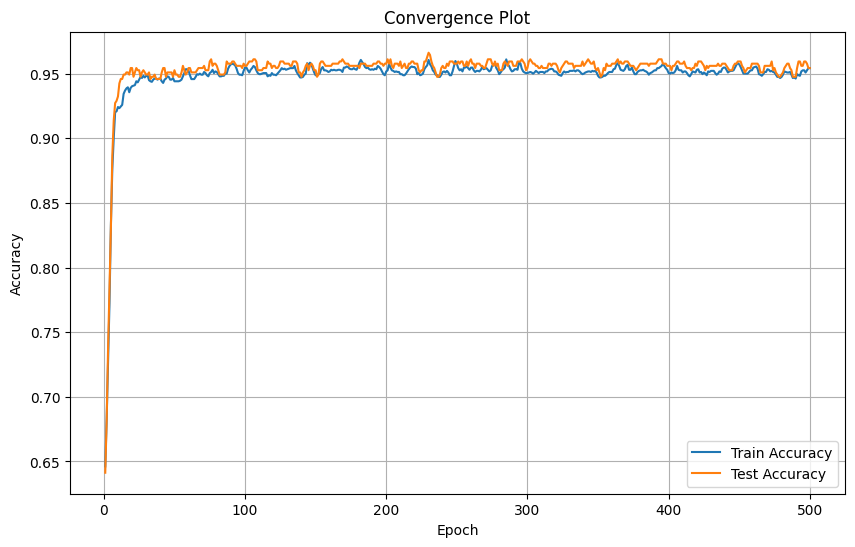

In [ ]:
# Plot the convergence of training and test accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, 501), train_acc_list, label='Train Accuracy')
plt.plot(range(1, 501), test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Convergence Plot')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
@torch.no_grad()
def evaluate_model(data, model):
    model.eval()  # Set the model to evaluation mode
    out = model(data)  # Get the output of the model (log probabilities)
    
    # Get the predicted classes and actual classes for the test set
    pred = out[data.test_mask].max(1)[1]  # Get the index of the max log-probability
    actual = data.y[data.test_mask]  # Actual labels
    
    # Calculate accuracy
    correct = pred.eq(actual).sum().item()  # Count of correct predictions
    total = data.test_mask.sum().item()  # Total number of test samples
    accuracy = correct / total  # Accuracy as a ratio
    
    print(f'Test Accuracy: {accuracy:.4f}')
    
    # Print a few sample predictions versus actual values
    print("\nSample Predictions:")
    num_samples = min(100, len(pred))  # Show up to 10 samples
    for i in range(num_samples):
        print(f'Predicted: {pred[i].item()}, Actual: {actual[i].item()}')

# Call the evaluation function after training is complete
evaluate_model(data, model)


Test Accuracy: 0.9543

Sample Predictions:
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual:

Test Accuracy: 0.9611


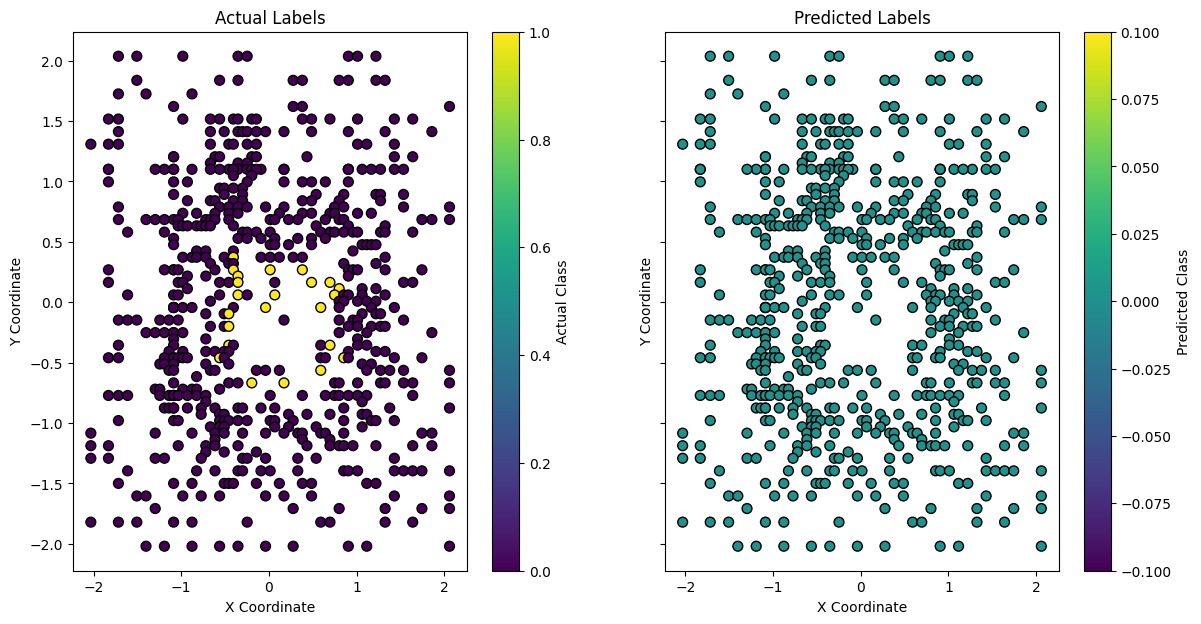

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

@torch.no_grad()
def evaluate_model(data, model, rotation_angle_degrees=-45):  # Assuming a rotation was applied initially
    model.eval()  # Set the model to evaluation mode
    out = model(data)  # Get the output of the model (log probabilities)
    
    # Get the predicted classes and actual classes for the test set
    pred = out[data.test_mask].max(1)[1]  # Get the index of the max log-probability
    actual = data.y[data.test_mask]  # Actual labels
    
    # Calculate accuracy
    correct = pred.eq(actual).sum().item()  # Count of correct predictions
    total = data.test_mask.sum().item()  # Total number of test samples
    accuracy = correct / total  # Accuracy as a ratio
    
    print(f'Test Accuracy: {accuracy:.4f}')
    
    # Reverse rotation for visualization
    angle = np.radians(rotation_angle_degrees)
    rotation_matrix = np.array([
        [np.cos(angle), np.sin(angle)],
        [-np.sin(angle), np.cos(angle)]
    ])
    coords = data.x[data.test_mask][:, :2].numpy()  # Assuming the first two columns in x are coordinates
    new_coords = np.dot(coords, rotation_matrix)  # Reverse the rotation applied earlier

    # Visualization of 2D predictions
    actual_colors = actual.numpy()
    predicted_colors = pred.numpy()

    fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharex=True, sharey=True)
    scatter = ax[0].scatter(new_coords[:, 0], new_coords[:, 1], c=actual_colors, cmap='viridis', edgecolor='k', s=50)
    ax[0].set_title('Actual Labels')
    ax[0].set_xlabel('X Coordinate')
    ax[0].set_ylabel('Y Coordinate')
    plt.colorbar(scatter, ax=ax[0], label='Actual Class')

    scatter = ax[1].scatter(new_coords[:, 0], new_coords[:, 1], c=predicted_colors, cmap='viridis', edgecolor='k', s=50)
    ax[1].set_title('Predicted Labels')
    ax[1].set_xlabel('X Coordinate')
    ax[1].set_ylabel('Y Coordinate')
    plt.colorbar(scatter, ax=ax[1], label='Predicted Class')

    plt.show()

# Call the evaluation function after training is complete
evaluate_model(data, model)
